<a href="https://colab.research.google.com/github/Zibraan/My_ML_DL_Codes/blob/main/Lung_Disease_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)

import shap


In [ ]:
lung = pd.read_csv("lung_disease_v1.csv")
print(lung.shape)
lung.head()


(12000, 33)


,patient_id,age,sex,bmi,smoking_status,pack_years,pm25_exposure,occupation,family_history,cough,...,dlco_pct_pred,cxr_finding,ct_nodule_size_mm,ct_emphysema_pct,sixmwd_m,hypertension,diabetes,hospital_visits_last_year,disease_type,severity
0,1,49,Male,20.1,Never,21.0,20.8,Office,NaN,1,...,82.1,Normal,3.0,11.9,447,1,1,0,Asthma,Moderate
1,2,61,Female,28.4,Current,34.1,10.8,Office,NaN,0,...,81.1,Normal,5.9,2.1,394,0,0,0,Lung Cancer,Mild/None
2,3,70,Male,22.2,Current,15.7,12.0,Manufacturing,NaN,1,...,85.4,Consolidation,2.8,4.8,309,0,1,0,Pneumonia,Mild/None
3,4,47,Male,23.1,Current,49.0,20.0,Manufacturing,NaN,0,...,49.0,Normal,1.8,29.4,190,0,0,0,COPD,Moderate
4,5,70,Female,29.0,Former,6.0,6.0,Office,NaN,0,...,81.6,Normal,1.0,9.5,314,0,0,0,Healthy,Mild/None


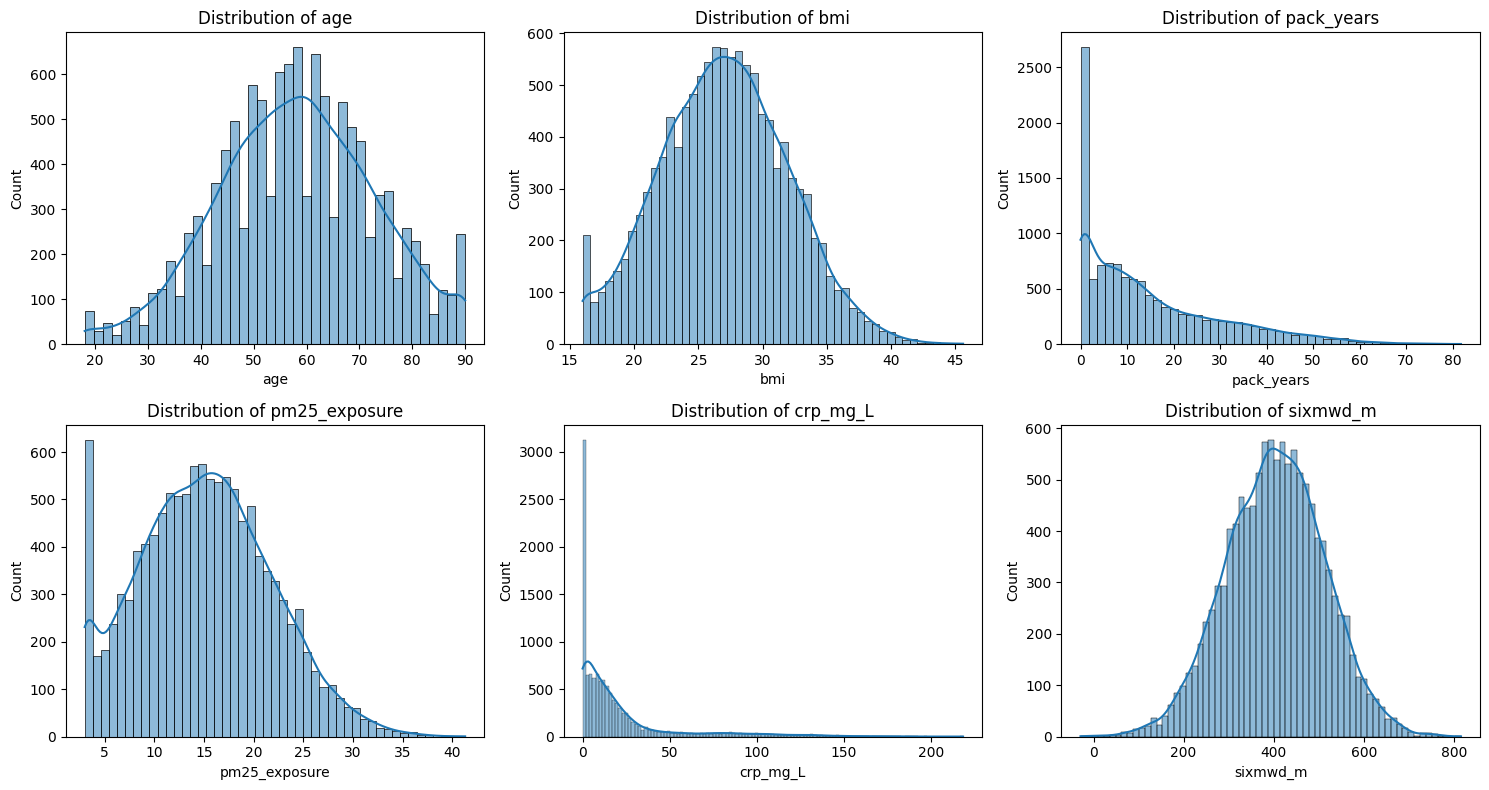

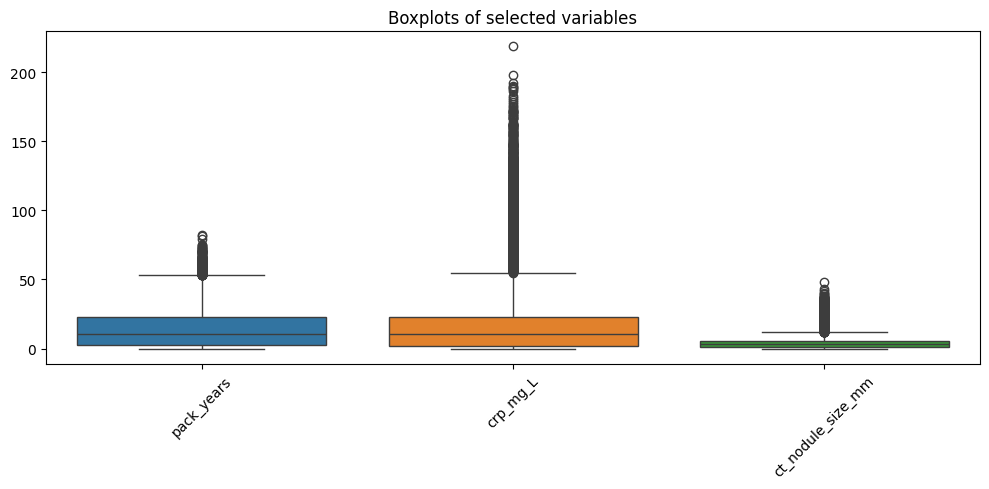

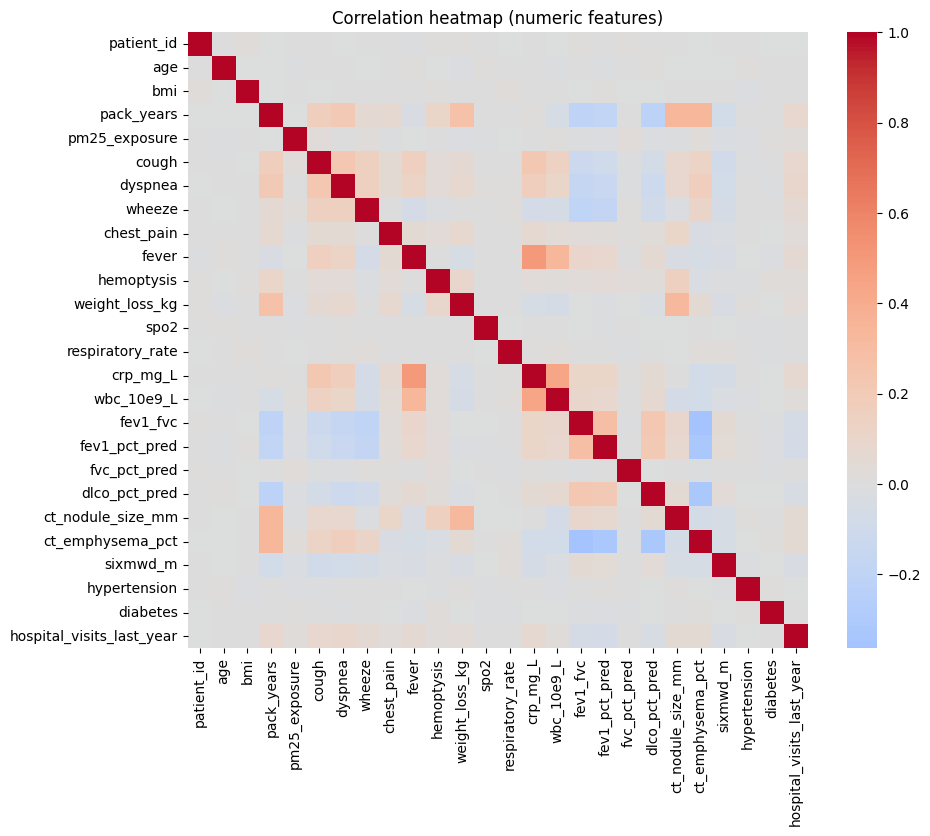

In [ ]:
# Missing values
lung.isna().sum()

# Target distribution
target = "disease_type"
lung[target].value_counts(normalize=True)

# Descriptive statistics of key numeric features
num_cols_basic = [
    "age", "bmi", "pack_years", "pm25_exposure",
    "fev1_fvc", "fev1_pct_pred", "fvc_pct_pred", "dlco_pct_pred",
    "sixmwd_m", "crp_mg_L"
]
lung[num_cols_basic].describe().T

# Histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, col in zip(axes.flatten(), ["age", "bmi", "pack_years", "pm25_exposure", "crp_mg_L", "sixmwd_m"]):
    sns.histplot(lung[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Boxplots for some clinical variables
plt.figure(figsize=(10, 5))
sns.boxplot(data=lung[["pack_years", "crp_mg_L", "ct_nodule_size_mm"]])
plt.title("Boxplots of selected variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric features
num_cols_all = lung.select_dtypes(include=["int64", "float64"]).columns
plt.figure(figsize=(10, 8))
corr = lung[num_cols_all].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.show()

In [ ]:
# Handle familyhistory "missing" category explicitly
lung["family_history"] = lung["family_history"].fillna("Missing")

# Define target and features, drop ID
y = lung[target]
X = lung.drop(columns=[target, "patient_id"])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Column types
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

# Preprocessor
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(
        multi_class="multinomial", max_iter=1000, n_jobs=-1
    ),
    "SVC": SVC(probability=True),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}

pipelines = {
    name: Pipeline(steps=[("preprocess", preprocess), ("model", clf)])
    for name, clf in models.items()
}


In [ ]:
results = []

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    report = classification_report(
        y_test, y_pred, output_dict=True, zero_division=0
    )

    results.append({
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
        "f1_macro": report["macro avg"]["f1-score"],
    })

results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,model,accuracy,precision_macro,recall_macro,f1_macro
0,LogisticRegression,0.941667,0.949101,0.937627,0.942840
1,SVC,0.938333,0.947597,0.931467,0.938940
2,DecisionTree,0.889167,0.895168,0.891681,0.893167
3,RandomForest,0.943333,0.952701,0.937619,0.944301
4,KNN,0.862083,0.891905,0.837702,0.859763
5,GradientBoosting,0.937083,0.944100,0.932494,0.937709


In [ ]:
rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
}

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ]
)

rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

rf_grid.fit(X_train, y_train)

print("Best params:", rf_grid.best_params_)
print("Best CV f1_macro:", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_tuned))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV f1_macro: 0.9450986832994629
              precision    recall  f1-score   support

      Asthma       0.91      0.77      0.83       394
        COPD       0.98      0.97      0.98       429
     Healthy       0.90      0.98      0.94       849
 Lung Cancer       0.99      0.98      0.98       356
   Pneumonia       0.99      0.99      0.99       372

    accuracy                           0.94      2400
   macro avg       0.95      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



In [ ]:
baseline_rf = pipelines["RandomForest"]
baseline_rf.fit(X_train, y_train)
y_pred_base = baseline_rf.predict(X_test)

comparison = pd.DataFrame([
    {
        "model": "RandomForest_baseline",
        "accuracy": accuracy_score(y_test, y_pred_base),
        "f1_macro": f1_score(y_test, y_pred_base, average="macro"),
    },
    {
        "model": "RandomForest_tuned",
        "accuracy": accuracy_score(y_test, y_pred_tuned),
        "f1_macro": f1_score(y_test, y_pred_tuned, average="macro"),
    },
])
comparison


,model,accuracy,f1_macro
0,RandomForest_baseline,0.943333,0.944301
1,RandomForest_tuned,0.942500,0.942948


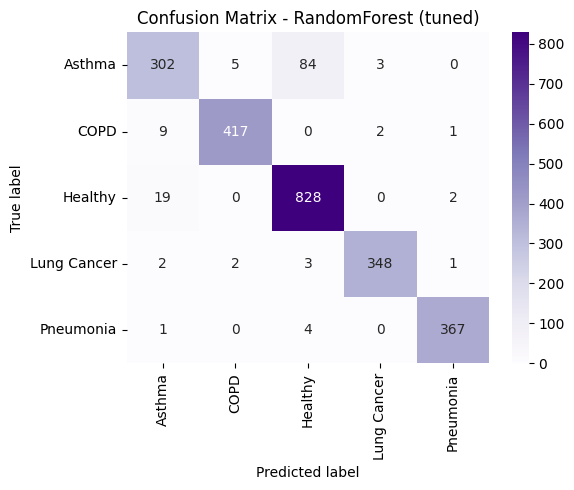

In [ ]:
cm = confusion_matrix(y_test, y_pred_tuned, labels=best_rf.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=best_rf.classes_,
            yticklabels=best_rf.classes_,
            cmap="Purples")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - RandomForest (tuned)")
plt.tight_layout()
plt.show()


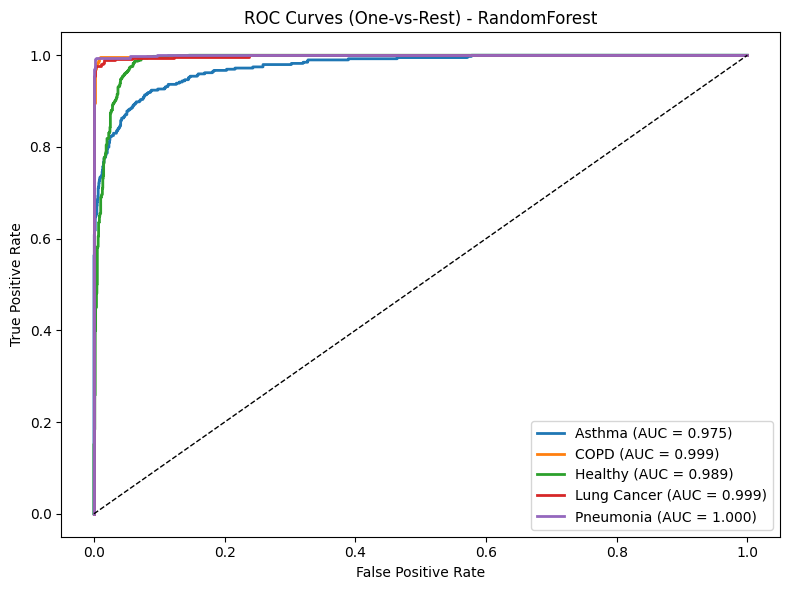

In [ ]:
# Probabilities for each class
y_proba = best_rf.predict_proba(X_test)

# Binarize true labels
classes = best_rf.classes_
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(8, 6))

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) - RandomForest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 24 candidates, totalling 72 fits


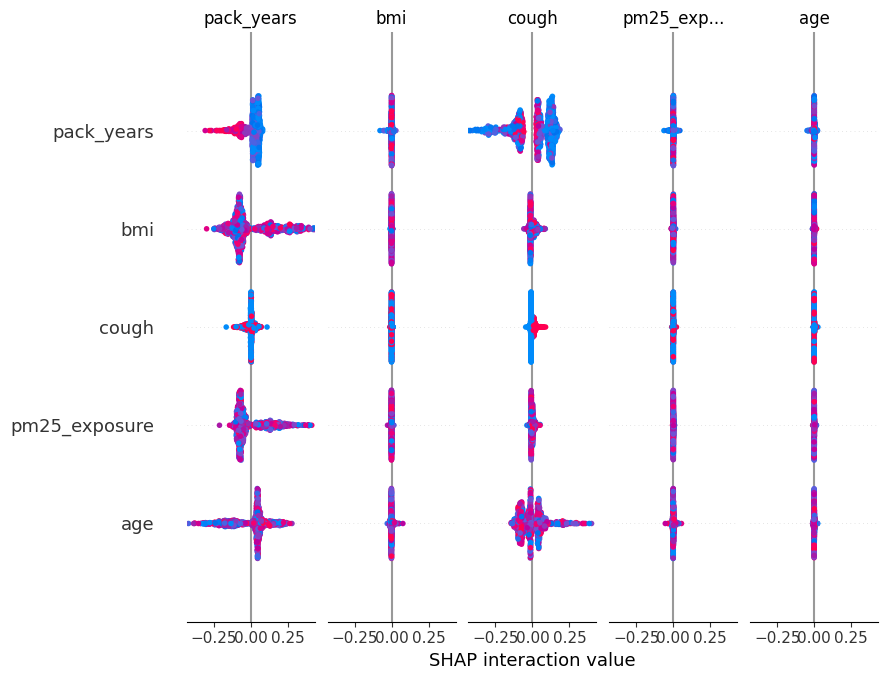

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import shap

# --- Start of definitions from previous cells needed for preprocess and data split ---

# Data loading from cell l8j0BCjZmzYQ
lung = pd.read_csv("lung_disease_v1.csv")

# Target definition
target = "disease_type"

# Preprocessing steps from cell ekBS7LX1m7sE
lung["family_history"] = lung["family_history"].fillna("Missing")

y = lung[target]
X = lung.drop(columns=[target, "patient_id"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)
# --- End of definitions from previous cells ---

# Re-define rf_param_grid, rf_pipeline, rf_grid and execute fit to ensure best_rf is defined.
# This re-runs the GridSearchCV for Random Forest within this cell.
rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
}

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ]
)

rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

# Fit rf_grid to ensure best_rf is defined. This might take some time.
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_

# Extract RF and transformed training data
rf_model = best_rf.named_steps["model"]
X_train_transformed = best_rf.named_steps["preprocess"].transform(X_train)

# Feature names after preprocessing
feature_names_cat = best_rf.named_steps["preprocess"] \
    .named_transformers_["cat"] \
    .get_feature_names_out(cat_cols)
feature_names_all = list(num_cols) + list(feature_names_cat)

# Use a smaller sample for SHAP to speed it up
X_shap = X_train_transformed[:1000]

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names_all,
    plot_type="interaction"
)
